In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
import os
import struct
import nltk
#nltk.download() 
from nltk.tag import pos_tag # pos_tag shows the characteristic of a word 
                             # using information in the database

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics.pairwise import cosine_similarity

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Install Empath tool for analyzing text across lexical categories
import sys
!{sys.executable} -m pip install empath

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
from empath import Empath

In [5]:
import nltk
# nltk.download('vader_lexicon')

## Part 1 Data Preparation
### 1.1 Data Import

In [6]:
df = pd.read_csv("./data/Combined_News_DJIA.csv", header = 0, index_col = 0)

In [7]:
df.tail()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-27,0,Barclays and RBS shares suspended from trading...,Pope says Church should ask forgiveness from g...,Poland 'shocked' by xenophobic abuse of Poles ...,"There will be no second referendum, cabinet ag...","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid ...,No negative news about South African President...,Surge in Hate Crimes in the U.K. Following U.K...,Weapons shipped into Jordan by the CIA and Sau...,...,German lawyers to probe Erdogan over alleged w...,"Boris Johnson says the UK will continue to ""in...",Richard Branson is calling on the UK governmen...,Turkey 'sorry for downing Russian jet',Edward Snowden lawyer vows new push for pardon...,Brexit opinion poll reveals majority don't wan...,"Conservative MP Leave Campaigner: ""The leave c...","Economists predict UK recession, further weake...","New EU 'superstate plan by France, Germany: Cr...",Pakistani clerics declare transgender marriage...
2016-06-28,1,"2,500 Scientists To Australia: If You Want To ...","The personal details of 112,000 French police ...",S&amp;P cuts United Kingdom sovereign credit r...,Huge helium deposit found in Africa,CEO of the South African state broadcaster qui...,"Brexit cost investors $2 trillion, the worst o...",Hong Kong democracy activists call for return ...,Brexit: Iceland president says UK can join 'tr...,UK's Osborne: 'Absolutely' going to have to cu...,...,"US, Canada and Mexico pledge 50% of power from...",There is increasing evidence that Australia is...,"Richard Branson, the founder of Virgin Group, ...","37,000-yr-old skull from Borneo reveals surpri...",Palestinians stone Western Wall worshipers; po...,Jean-Claude Juncker asks Farage: Why are you h...,"""Romanians for Remainians"" offering a new home...",Brexit: Gibraltar in talks with Scotland to st...,8 Suicide Bombers Strike Lebanon,Mexico's security forces routinely use 'sexual...
2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offs...,UK must accept freedom of movement to access E...,Devastated: scientists too late to captive bre...,British Labor Party leader Jeremy Corbyn loses...,A Muslim Shop in the UK Was Just Firebombed Wh...,Mexican Authorities Sexually Torture Women in ...,UK shares and pound continue to recover,Iceland historian Johannesson wins presidentia...,...,"Escape Tunnel, Dug by Hand, Is Found at Holoca...",The land under Beijing is sinking by as much a...,Car bomb and Anti-Islamic attack on Mosque in ...,Emaciated lions in Taiz Zoo are trapped in blo...,Rupert Murdoch describes Brexit as 'wonderful'...,More than 40 killed in Yemen suicide attacks,Google Found Disastrous Symantec and Norton Vu...,Extremist violence on the rise in Germany: Dom...,BBC News: Labour MPs pass Corbyn no-confidence...,Tiny New Zealand town with 'too many jobs' lau...
2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says pollution and 'stupidity'...,Boris Johnson says he will not run for Tory pa...,Six gay men in Ivory Coast were abused and for...,Switzerland denies citizenship to Muslim immig...,Palestinian terrorist stabs israeli teen girl ...,Puerto Rico will default on $1 billion of debt...,Republic of Ireland fans to be awarded medal f...,Afghan suicide bomber 'kills up to 40' - BBC News,...,Googles free wifi at Indian railway stations i...,Mounting evidence suggests 'hobbits' were wipe...,The men who carried out Tuesday's terror attac...,Calls to suspend Saudi Arabia from UN Human Ri...,More Than 100 Nobel Laureates Call Out Greenpe...,British pedophile sentenced to 85 years in US ...,"US permitted 1,200 offshore fracks in Gulf of ...",We will be swimming in ridicule - French beach...,UEFA says no minutes of silence for Istanbul v...,Law Enforcement Sources: Gun Used in Paris Ter...
2016-07-01,1,A 117-year-old woman 

In [8]:
df.shape

(1989, 26)

In [9]:
df.iloc[0,1]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"'

### 1.2 Data Preparation - Tokenization

In [10]:
stop_words = []
f = open('./data/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words
# The list "stop_words" has 668 words in it

In [11]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    import re
    text = str(text)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [12]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation

[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to D:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
def tokenizer(text):
    from functools import reduce
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

In [14]:
# tokenize each headline in df
for top in df.columns[1:]:
    df[top] = df[top].map(lambda d: tokenizer(d))

In [15]:
import pickle
with open('tokenized_df','wb') as f:
    pickle.dump(df,f)

In [16]:
with open('tokenized_df','rb') as f:
    tokenized_df = pickle.load(f)
tokenized_df.head()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"[georgia, owns, russian, warplanes, countries,...","[breaking, musharraf, impeached]","[russia, today, columns, troops, roll, south, ...","[russian, tanks, moving, capital, south, osset...","[afghan, children, raped, impunity, official, ...","[russian, tanks, entered, south, ossetia, whil...","[breaking, georgia, invades, south, ossetia, r...","[enemy, combatent, trials, sham, salim, haman,...","[georgian, troops, retreat, osettain, capital,...",...,"[georgia, invades, south, ossetia, russia, inv...","[al, qaeda, faces, islamist, backlash]","[condoleezza, rice, prevent, israeli, strike, ...","[busy, day, european, union, approved, sanctio...","[georgia, withdraw, soldiers, iraq, help, figh...","[pentagon, thinks, attacking, iran, bad, idea,...","[caucasus, crisis, georgia, invades, south, os...","[indian, shoe, manufactory, series, work]","[visitors, suffering, mental, illnesses, banne...","[help, mexico, kidnapping, surge]"
2008-08-11,1,"[america, nato, help, help, help, iraq]","[bush, puts, foot, georgian, conflict]","[jewish, georgian, minister, israeli, training...","[georgian, army, flees, disarray, russians, ad...","[olympic, opening, ceremony, fireworks, faked]","[mossad, fraudulent, zealand, passports, iraq]","[russia, angered, israeli, military, sale, geo...","[american, citizen, living, ossetia, blames, g...","[war, iv, high, definition]",...,"[israel, georgian, aggression]","[tv, russian, georgian, victims]","[riots, going, montreal, canada, police, murde...","[china, overtake, largest, manufacturer]","[war, south, ossetia, pics]","[israeli, physicians, group, condemns, state, ...","[russia, beaten, united, states, head, peak, oil]","[question, georgia, russia, conflict]","[russia, better, war]","[trading, sex, food]"
2008-08-12,0,"[member, adorable, year, sang, opening, ceremo...","[russia, ends, georgia, operation]","[sexual, harassment, children]","[al, qa, eda, losing, support, iraq, brutal, c...","[ceasefire, georgia, putin, outmaneuvers, west]","[microsoft, intel, kill, xo, laptop]","[tratfor, russo, georgian, war, balance, power]","[sense, georgia, russia, war, vote, georgia, s...","[military, surprised, timing, swiftness, russi...",...,"[troops, georgia, georgia, place]","[russias, response, georgia]","[gorbachev, accuses, making, serious, blunder,...","[russia, georgia, nato, cold, war]","[member, adorable, year, led, country, war, ba...","[war, georgia, israeli, connection]","[signs, point, encouraging, georgia, invade, s...","[christopher, king, argues, nato, georgian, in...","[america, mexico]","[bbc, news, asia, pacific, extinction, man, cl..."
2008-08-13,0,"[refuses, israel, weapons, attack, iran, report]","[president, ordered, attack, tskhinvali, capit...","[israel, clears, troops, killed, reuters, came...","[britain, policy, tough, drugs, pointless, civ...","[body, year, trunk, latest, ransom, paid, kidn...","[china, moved, quake, survivors, prefab, homes]","[bush, announces, operation, russia, grill, ye...","[russian, forces, sink, georgian, ships]","[commander, navy, air, reconnaissance, squadro...",...,"[elephants, extinct]","[humanitarian, missions, georgia, russia, hits...","[georgia, ddos, sources]","[russian, convoy, heads, georgia, violating, t...","[israeli, defence, minister, strike, iran]","[gorbachev, choice]","[witness, russian, forces, head, tbilisi, brea...","[quarter, russians, blame, conflict, poll]","[georgian, president, military, control, seapo...","[nobel, laureate, aleksander, solzhenitsyn, ac..."
2008-08-14,1,"[experts, admit, legalise, drugs]","[war, south, osetia, pictures, russian, soldier]","[wedish, wrestler, ara, abrahamian, throws, me...","[russia, exaggerated, death, toll, south, osse...","[missile, killed, inside, pakistan, launched, ...","[rushdie, condemns, random, house, refusal, pu...","[poland, agree, missle, d

## Part 2 Filter headlines by topic

### 2.1 Use Empath to filter headlines 

In [17]:
from empath import Empath
lexicon = Empath()

In [18]:
for i in range(tokenized_df.shape[0]):
    for j in range(1, tokenized_df.shape[1]):
        if tokenized_df.iloc[i, j]:
            topic_scores = lexicon.analyze(' '.join(tokenized_df.iloc[i, j]),\
                                               categories=['economics', 'technology', 'politics'], normalize=True)
            if sum(topic_scores.values()) == 0.:
                tokenized_df.iloc[i, j] = np.NaN
        else:
            tokenized_df.iloc[i, j] = np.NaN

In [19]:
tokenized_df.head()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"[busy, day, european, union, approved, sanctio...",NaN,NaN,NaN,NaN,NaN,NaN
2008-08-11,1,NaN,NaN,NaN,NaN,NaN,NaN,"[russia, angered, israeli, military, sale, geo...","[american, citizen, living, ossetia, blames, g...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[trading, sex, food]"
2008-08-12,0,NaN,NaN,NaN,"[al, qa, eda, losing, support, iraq, brutal, c...",NaN,"[microsoft, intel, kill, xo, laptop]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-13,0,NaN,NaN,NaN,"[britain, policy, tough, drugs, pointless, civ...",NaN,NaN,NaN,NaN,"[commander, navy, air, reconnaissance, squadro...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-14,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"[war, caucasus, product, american, imperial, d...",NaN,NaN,NaN,NaN,NaN,NaN,"[philippines, peace, advocate, muslims, assura..."


In [20]:
# check if all top25 headlines are filtered out in each day
sum(tokenized_df.isnull().all(axis = 1))

0

In [21]:
# save filtered dataframe
with open('filtered_tokenized_df', 'wb') as f:
    pickle.dump(tokenized_df, f)

### 2.2 Sentiment Analysis on Headlines Left

In [22]:
with open('filtered_tokenized_df', 'rb') as f:
    filtered_tokenized_df = pickle.load(f)

In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
result = []

for i in range(filtered_tokenized_df.shape[0]):
    compound = []
    neutral =[]
    positive = []
    negative = []
    list_of_headlines = filtered_tokenized_df.iloc[i, :][filtered_tokenized_df.iloc[i, :].notnull()][1:].tolist()
    for headline in list_of_headlines:
        pol_score = sia.polarity_scores(' '.join(headline))
        compound.append(pol_score['compound'])
        neutral.append(pol_score['neu'])
        positive.append(pol_score['pos'])
        negative.append(pol_score['neg'])
    result.append({'compound': np.mean(compound), 'neu': np.mean(neutral), 'pos': np.mean(positive), 'neg': np.mean(negative)})

In [24]:
sentiment_score_df = pd.DataFrame.from_records(result)
sentiment_score_df.set_index(filtered_tokenized_df.index, inplace=True)

In [25]:
sentiment_score_df['Label'] = filtered_tokenized_df['Label']

In [26]:
sentiment_score_df.head()

,compound,neg,neu,pos,Label
Date,,,,,
2008-08-08,0.20230,0.15600,0.62500,0.21900,0
2008-08-11,-0.14695,0.15100,0.80325,0.04575,1
2008-08-12,-0.65160,0.43400,0.49950,0.06600,0
2008-08-13,-0.13415,0.23475,0.67050,0.09450,0
2008-08-14,0.03240,0.17375,0.60600,0.22025,1


In [27]:
with open('sentiment_score_df', 'wb') as f:
    pickle.dump(sentiment_score_df, f)

## Part 3 Vocabulary Construction
This part contains only functions, which will later be called when training and validating the models.

In [163]:
'''
The following two functions are used to help extract terminology and meaningful words
REFERENCE: http://bdewilde.github.io/blog/2014/09/23/intro-to-automatic-keyphrase-extraction/
'''
def extract_candidate_chunks(text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'):
    import itertools, nltk, string

    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize, POS-tag, and chunk using regular expressions
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    tagged_sents = nltk.pos_tag_sents(nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text))
    all_chunks = list(itertools.chain.from_iterable(nltk.chunk.tree2conlltags(chunker.parse(tagged_sent))
                                                    for tagged_sent in tagged_sents))

    # join constituent chunk words into a single chunked phrase
    candidates = [' '.join(word for word, pos, chunk in group).lower()
                  for key, group in itertools.groupby(all_chunks, lambda (word,pos,chunk): chunk != 'O') if key]

    return [cand for cand in candidates
            if cand not in stop_words and not all(char in punct for char in cand)]

In [164]:
'''
Input a ordered word list, output its vocabulary set
'''
def buildVocabulary(OrderedWord):
    # Single words that we think may be meaningful.
    good_pos_tag_set = set(['JJ','JJR','JJS', # adjective
                        'NN','NNP','NNS','NNPS', # noun
                        'RB','RBR','RBS','RP', # adverb and particle
                        'VB','VBD','VBG','VBN','VBP','VBZ']) # verb
    String = ' '.join(OrderedWord)
    word_candidate = OrderedWord
    word_final = []
    for i in range(len(word_candidate)):
        posTag = pos_tag([str(word_candidate[i])])[0][1]
        isGood = (good_pos_tag_set.union([posTag])==good_pos_tag_set)
        if isGood:
            word_final.append(str(word_candidate[i]))
    phase_final = extract_candidate_chunks(String, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}')
    for p in phase_final:
        if (len(tokenizer(p))>4):
            phase_final.remove(p)
    term_final = set(word_final)|set(phase_final)
    return term_final

In [165]:
'''
Input a headline list of list where the element refers to
a headline in the form of list of its ordered good words.
Return a set of vocabulary generated from the input.
It takes around 2 minutes to generate a vocabulary for a 
input contains 1500 days' headlines.
'''
def getVocabulary(headlines_input):
    vocabulary = set([])
    for i in range(len(headlines_input)):
        for s in headlines_input[i]:
            if(type(s)!=list):
                continue
            else:
                vocabulary = vocabulary|buildVocabulary(s)
        #if (i%15==0):
            #print i/15
    final_vocabulary = []
    c = 0
    for term in vocabulary:
        if (len(term.split())<=4):
            final_vocabulary.append(term)
    final_vocabulary = set(final_vocabulary)
    #print len(final_vocabulary)
    return final_vocabulary

## Part 4 Input for Models

In [166]:
'''
Input a headline list of list where the element refers to
a headline in the form of list of its ordered good words.
Return a list where the element refers to a day's all good
headlines as a whole headline string.
'''
def toHeadlines(headlines_input):
    headlines_output = [0]*len(headlines_input)
    for i in range(len(headlines_input)):
        headlines_output[i] = []
        for s in headlines_input[i]:
            if(type(s)==list):
                headlines_output[i].append(' '.join(s))
        temp = ' '.join(headlines_output[i])
        headlines_output[i] = temp
    return headlines_output

In [212]:
'''
Input a headlines input and a vocabulary.
Headlines_input is a headline list of list where the element refers to
a headline in the form of list of its ordered good words.
Return a tfidf matrix with respect to the vocabulary, but some terms
with too low or too high frequency are excluded.
'''
def getTfidfMat(headlines_input, vocabulary):
    headlines_str = toHeadlines(headlines_input)
    TFIDF = TfidfVectorizer(min_df=0.03, max_df=0.97, ngram_range=(1, 4))
    FitResult = TFIDF.fit(headlines_str)
    freq_vocabulary = set(FitResult.get_feature_names())
    VOCA = []
    for t in freq_vocabulary:
        if t in vocabulary:
            VOCA.append(t)
    TFIDF2 = TfidfVectorizer(vocabulary = VOCA)
    tfidf_mat = TFIDF2.fit_transform(headlines_str)
    return tfidf_mat,VOCA

def getTfidfMat2(headlines_input, vocabulary):
    headlines_str = toHeadlines(headlines_input)
    TFIDF2 = TfidfVectorizer(vocabulary=vocabulary)
    tfidf_mat = TFIDF2.fit_transform(headlines_str)
    return tfidf_mat

In [213]:
def getInput(headlines_t,DJIA_t,headlines_v,DJIA_v):
    VOC = getVocabulary(headlines_t)
    HEAD_t = getTfidfMat(headlines_t,VOC)[0]
    VOCA = getTfidfMat(headlines_t,VOC)[1]
    HEAD_v = getTfidfMat2(headlines_v,VOCA)    
    return HEAD_t,DJIA_t,HEAD_v,DJIA_v

In [214]:
'''
Seperate the data into training set and test set.
And in the training set, seperate ten validation groups.
Each group contains a subtraining set of 700 points and a validation set
of 100 points.
'''
headlines = tokenized_df.as_matrix(columns = tokenized_df.columns[1:])
DJIA = df.Label[:].values
headlines_train = headlines[:1700]
headlines_test = headlines[1700:]
DJIA_train = df.Label[:1700].values
DJIA_test = df.Label[1700:].values

In [224]:
FORMALset = getInput(headlines_train,DJIA_train,headlines_test,DJIA_test)

In [216]:
CVset = [0]*10
CVset[0] = getInput(headlines[:700],DJIA[:700],headlines[700:800],DJIA[700:800])
CVset[1] = getInput(headlines[100:800],DJIA[100:800],headlines[800:900],DJIA[800:900])
CVset[2] = getInput(headlines[200:900],DJIA[200:900],headlines[900:1000],DJIA[900:1000])
CVset[3] = getInput(headlines[300:1000],DJIA[300:1000],headlines[1000:1100],DJIA[1000:1100])
CVset[4] = getInput(headlines[400:1100],DJIA[400:1100],headlines[1100:1200],DJIA[1100:1200])
CVset[5] = getInput(headlines[500:1200],DJIA[500:1200],headlines[1200:1300],DJIA[1200:1300])
CVset[6] = getInput(headlines[600:1300],DJIA[600:1300],headlines[1300:1400],DJIA[1300:1400])
CVset[7] = getInput(headlines[700:1400],DJIA[700:1400],headlines[1400:1500],DJIA[1400:1500])
CVset[8] = getInput(headlines[800:1500],DJIA[800:1500],headlines[1500:1600],DJIA[1500:1600])
CVset[9] = getInput(headlines[900:1600],DJIA[900:1600],headlines[1600:1700],DJIA[1600:1700])

In [226]:
with open('FORMALset','wb') as fm:
    pickle.dump(FORMALset,fm)
with open('FORMALset','rb') as fm:
    FORMALset = pickle.load(fm)
FORMALset

with open('CVset','wb') as cv:
    pickle.dump(CVset,cv)
with open('CVset','rb') as cv:
    CVset = pickle.load(cv)
CVset

[(<700x369 sparse matrix of type '<type 'numpy.float64'>'
  	with 15630 stored elements in Compressed Sparse Row format>,
  array([0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
         1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
         0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
         0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
         1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
         1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
         1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
         0, 1, 1, 0,

In [ ]:
'''
Simulated data: FOR MODEL TEST ONLY!
'''
# Model test data
x1 = np.random.normal(0,1,2000)
x2 = np.random.normal(2,5,2000)
x3 = np.random.normal(0,4,2000)
y = (2*x1+(0.5*x2+3)*x3>5)
X = [0]*2000
for i in range(2000):
    X[i] = [x1[i],x2[i],x3[i]]
train_term_document_matrix_tfidf = np.array(X[:1500])
test_term_document_matrix_tfidf = np.array(X[1500:])
DJIA_train = y[:1500]
DJIA_test = y[1500:]

## Part 6 Prediction Models

### 6.0 Benchmarks

In [285]:
def Bullish(X_train, Y_train, X_test, Y_test):
    train_predict = np.ones(len(Y_train))
    test_predict = np.ones(len(Y_test))   
    accu_train = sum(Y_train == train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == test_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    TP = sum(Y_test*test_predict==1)
    TN = sum(Y_test+test_predict==0)
    FP = sum(Y_test<test_predict)
    FN = sum(Y_test>test_predict)
    tpr = TP/float(TP+FN)
    fpr = FP/float(FP+TN)
    return error_train,error_test,tpr,fpr

In [286]:
Bull_CVerror = 0.
for i in range(10):
    Bull_CVerror = Bull_CVerror+0.1*Bullish(CVset[i][0],CVset[i][1],CVset[i][2],CVset[i][3])[1]
Bull = Bullish(FORMALset[0],FORMALset[1],FORMALset[2],FORMALset[3])
print "Bullish: Market All Up"
print "Training Error:\t",Bull[0]
print "CV Error:\t",Bull_CVerror
print "Test Error:\t",Bull[1]
print "Test True Positive Rate:\t",Bull[2]
print "Test False Positive Rate:\t",Bull[3]

Bullish: Market All Up
Training Error:	0.46
CV Error:	0.465
Test Error:	0.491349480969
Test True Positive Rate:	1.0
Test False Positive Rate:	1.0


In [301]:
'''
First day has not historical data, give the value 0 as 
a conservative view on the market.
'''
def Reversal(X_train, Y_train, X_test, Y_test):
    train_predict = 1-np.insert(Y_train[:-1],0,1)
    test_predict = 1-np.insert(Y_test[:-1],0,1)
    accu_train = sum(Y_train == train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == test_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    TP = sum(Y_test*test_predict==1)
    TN = sum(Y_test+test_predict==0)
    FP = sum(Y_test<test_predict)
    FN = sum(Y_test>test_predict)
    tpr = TP/float(TP+FN)
    fpr = FP/float(FP+TN)
    return error_train,error_test,tpr,fpr

In [303]:
Rev_CVerror = 0.
for i in range(10):
    Rev_CVerror = Rev_CVerror+0.1*Reversal(CVset[i][0],CVset[i][1],CVset[i][2],CVset[i][3])[1]
Rev = Reversal(FORMALset[0],FORMALset[1],FORMALset[2],FORMALset[3])
print "Reversal: Today down, tomorrow up, vice versa"
print "Training Error:\t",Rev[0]
print "CV Error:\t",Rev_CVerror
print "Test Error:\t",Rev[1]
print "Test True Positive Rate:\t",Rev[2]
print "Test False Positive Rate:\t",Rev[3]

Reversal: Today down, tomorrow up, vice versa
Training Error:	0.478235294118
CV Error:	0.475
Test Error:	0.467128027682
Test True Positive Rate:	0.52380952381
Test False Positive Rate:	0.457746478873


### 6.1 KNN

In [262]:
def KNN(X_train, Y_train, X_test, Y_test, K):
    """
    X_train: term_doc_matrix
    Y_train: list
    X_test: term_doc_matrix
    Y_test: list
    K: integer
    """
    pred_train = np.zeros(len(Y_train), dtype = 'int64')
    pred_test = np.zeros(len(Y_test), dtype = 'int64')
    inverted_index_test = { i[0]:i[1] for i in list(zip(range(len(Y_test)),Y_test))}
    inverted_index_train= { i[0]:i[1] for i in list(zip(range(len(Y_train)),Y_train))}
    sim_score_matrix_K_train = cosine_similarity(X_train, X_train)
    for j in range(sim_score_matrix_K_train.shape[0]):
        highest_K_score_index_train = np.argsort(sim_score_matrix_K_train[j])[-K:]
        DJIA_K_train = [inverted_index_train[idx] for idx in highest_K_score_index_train]
        Prob = (sum(DJIA_K_train)+0.)/len(DJIA_K_train) #smoothing
        if Prob >= 0.5:
            pred_train[j] = 1
        else:
            pred_train[j] = 0
    sim_score_matrix_K =  cosine_similarity(X_test, X_train)
    for j in range(sim_score_matrix_K.shape[0]):
        highest_K_score_index = np.argsort(sim_score_matrix_K[j])[-K:]
        DJIA_K = [inverted_index_train[idx] for idx in highest_K_score_index]
        Prob = (sum(DJIA_K)+0.)/len(DJIA_K) #smoothing
        if Prob >= 0.5:
            pred_test[j] = 1
        else:
            pred_test[j] = 0
    accu_train = np.mean(Y_train == pred_train)        
    accu_test = np.mean(Y_test == pred_test)
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    TP = sum(Y_test*pred_test==1)
    TN = sum(Y_test+pred_test==0)
    FP = sum(Y_test<pred_test)
    FN = sum(Y_test>pred_test)
    tpr = TP/float(TP+FN)
    fpr = FP/float(FP+TN)
    return error_train,error_test,tpr,fpr

Minimum CV Error: 0.478 	K = 4
KNN Model with K = 4
Training Error:	0.315882352941
CV Error:	0.478
Test Error:	0.519031141869
Test True Positive Rate:	0.727891156463
Test False Positive Rate:	0.774647887324


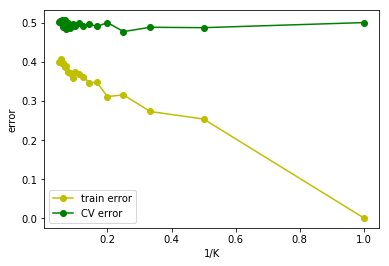

In [273]:
Knn = [0]*20
Knn_CVerror = [0]*20
for k in range(20):
    Knn_CVerror[k] = 0.
    for i in range(10):
        Knn_CVerror[k] = Knn_CVerror[k]+0.1*KNN(CVset[i][0],CVset[i][1],CVset[i][2],CVset[i][3],k+1)[1]
    Knn[k] = KNN(FORMALset[0],FORMALset[1],FORMALset[2],FORMALset[3],k+1)
Ktrain_error =[Knn[k][0] for k in range(20)]
one_over_k = [1.0/K for K in range(1, 21)]
plt.plot(one_over_k, Ktrain_error, '-yo', label = 'train error')
plt.plot(one_over_k, Knn_CVerror, '-go', label = 'CV error')
plt.ylabel('error')
plt.xlabel('1/K')
plt.legend(loc = 'lower left')
K_chosen = np.argmin(Knn_CVerror)+1
print "Minimum CV Error:",Knn_CVerror[K_chosen-1],"\tK =",K_chosen
print "KNN Model with K =",K_chosen
print "Training Error:\t",Knn[K_chosen-1][0]
print "CV Error:\t",Knn_CVerror[K_chosen-1]
print "Test Error:\t",Knn[K_chosen-1][1]
print "Test True Positive Rate:\t",Knn[K_chosen-1][2]
print "Test False Positive Rate:\t",Knn[K_chosen-1][3]

### 6.2 Logistic

In [241]:
from sklearn.linear_model import LogisticRegression
def Logit(X_train, Y_train, X_test, Y_test):
    logit = LogisticRegression()
    logit_fit = logit.fit(X_train, Y_train)
    logit_train_predict = logit.predict(X_train)
    logit_predict = logit.predict(X_test)
    accu_train = sum(Y_train == logit_train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == logit_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    TP = sum(Y_test*logit_predict==1)
    TN = sum(Y_test+logit_predict==0)
    FP = sum(Y_test<logit_predict)
    FN = sum(Y_test>logit_predict)
    tpr = TP/float(TP+FN)
    fpr = FP/float(FP+TN)
    return error_train,error_test,tpr,fpr

In [281]:
Logit0_CVerror = 0.
for i in range(10):
    Logit0_CVerror = Logit0_CVerror+0.1*Logit(CVset[i][0],CVset[i][1],CVset[i][2],CVset[i][3])[1]
Logit0 = Logit(FORMALset[0],FORMALset[1],FORMALset[2],FORMALset[3])
print "Logistic Model"
print "Training Error:\t",Logit0[0]
print "CV Error:\t",Logit0_CVerror
print "Test Error:\t",Logit0[1]
print "Test True Positive Rate:\t",Logit0[2]
print "Test False Positive Rate:\t",Logit0[3]

Logistic Model
Training Error:	0.295294117647
CV Error:	0.493
Test Error:	0.508650519031
Test True Positive Rate:	0.632653061224
Test False Positive Rate:	0.654929577465


In [243]:
def LogitLasso(X_train, Y_train, X_test, Y_test):
    logit = LogisticRegression(penalty='l1')
    logit_fit = logit.fit(X_train, Y_train)
    logit_train_predict = logit.predict(X_train)
    logit_predict = logit.predict(X_test)
    accu_train = sum(Y_train == logit_train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == logit_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    TP = sum(Y_test*logit_predict==1)
    TN = sum(Y_test+logit_predict==0)
    FP = sum(Y_test<logit_predict)
    FN = sum(Y_test>logit_predict)
    tpr = TP/float(TP+FN)
    fpr = FP/float(FP+TN)
    return error_train,error_test,tpr,fpr

In [244]:
LogitL_CVerror = 0.
for i in range(10):
    LogitL_CVerror = LogitL_CVerror+0.1*LogitLasso(CVset[i][0],CVset[i][1],CVset[i][2],CVset[i][3])[1]
LogitL = LogitLasso(FORMALset[0],FORMALset[1],FORMALset[2],FORMALset[3])
print "Logistic Lasso Model"
print "Training Error:\t",LogitL[0]
print "CV Error:\t",LogitL_CVerror
print "Test Error:\t",LogitL[1]
print "Test True Positive Rate:\t",LogitL[2]
print "Test False Positive Rate:\t",LogitL[3]

Logistic Lasso Model
Training Error:	0.347058823529
CV Error:	0.455
Test Error:	0.501730103806
Test True Positive Rate:	0.700680272109
Test False Positive Rate:	0.711267605634


In [245]:
def LogitRidge(X_train, Y_train, X_test, Y_test):
    logit = LogisticRegression(penalty='l2')
    logit_fit = logit.fit(X_train, Y_train)
    logit_train_predict = logit.predict(X_train)
    logit_predict = logit.predict(X_test)
    accu_train = sum(Y_train == logit_train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == logit_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    TP = sum(Y_test*logit_predict==1)
    TN = sum(Y_test+logit_predict==0)
    FP = sum(Y_test<logit_predict)
    FN = sum(Y_test>logit_predict)
    tpr = TP/float(TP+FN)
    fpr = FP/float(FP+TN)
    return error_train,error_test,tpr,fpr

In [246]:
LogitR_CVerror = 0.
for i in range(10):
    LogitR_CVerror = LogitR_CVerror+0.1*LogitRidge(CVset[i][0],CVset[i][1],CVset[i][2],CVset[i][3])[1]
LogitR = LogitRidge(FORMALset[0],FORMALset[1],FORMALset[2],FORMALset[3])
print "Logistic Ridge Model"
print "Training Error:\t",LogitR[0]
print "CV Error:\t",LogitR_CVerror
print "Test Error:\t",LogitR[1]
print "Test True Positive Rate:\t",LogitR[2]
print "Test False Positive Rate:\t",LogitR[3]

Logistic Ridge Model
Training Error:	0.295294117647
CV Error:	0.493
Test Error:	0.508650519031
Test True Positive Rate:	0.632653061224
Test False Positive Rate:	0.654929577465


### 6.3 Rocchio Classification

In [249]:
def Rocchio(X_train, Y_train, X_test, Y_test):
    pred_train = np.zeros(len(Y_train), dtype = 'int64')
    pred_test = np.zeros(len(Y_test), dtype = 'int64')
    X_train_1 = X_train[np.array(Y_train) == 1, :]
    X_train_0 = X_train[np.array(Y_train) == 0, :]
    Centriod_1 = (np.sum(X_train_1, axis = 0)+0.)/X_train_1.shape[0]
    Centriod_0 = (np.sum(X_train_0, axis = 0)+0.)/X_train_0.shape[0]
    for j in range(len(Y_train)):
        distance_1 = np.sqrt(np.sum(np.square(X_train[j]-Centriod_1)))
        distance_0 = np.sqrt(np.sum(np.square(X_train[j]-Centriod_0)))
        if distance_1 <= distance_0:
            pred_train[j] = 1
        else:
            pred_train[j] = 0
    accu_train = np.mean(Y_train == pred_train)
    for j in range(len(Y_test)):
        distance_1 = np.sqrt(np.sum(np.square(X_test[j]-Centriod_1)))
        distance_0 = np.sqrt(np.sum(np.square(X_test[j]-Centriod_0)))
        if distance_1 <= distance_0:
            pred_test[j] = 1
        else:
            pred_test[j] = 0
    accu_test = np.mean(Y_test == pred_test)
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test   
    TP = sum(Y_test*pred_test==1)
    TN = sum(Y_test+pred_test==0)
    FP = sum(Y_test<pred_test)
    FN = sum(Y_test>pred_test)
    tpr = TP/float(TP+FN)
    fpr = FP/float(FP+TN)
    return error_train,error_test,tpr,fpr

In [250]:
RC_CVerror = 0.
for i in range(10):
    RC_CVerror = RC_CVerror+0.1*Rocchio(CVset[i][0],CVset[i][1],CVset[i][2],CVset[i][3])[1]
RC = Rocchio(FORMALset[0],FORMALset[1],FORMALset[2],FORMALset[3])
print "Rocchio Classification Model"
print "Training Error:\t",RC[0]
print "CV Error:\t",RC_CVerror
print "Test Error:\t",RC[1]
print "Test True Positive Rate:\t",RC[2]
print "Test False Positive Rate:\t",RC[3]

Rocchio Classification Model
Training Error:	0.319411764706
CV Error:	0.504
Test Error:	0.512110726644
Test True Positive Rate:	0.517006802721
Test False Positive Rate:	0.542253521127


### 6.4 Naive Bayes

In [251]:
from sklearn.naive_bayes import BernoulliNB
def NaiveBayes(X_train, Y_train, X_test, Y_test):
    BNBclassifier = BernoulliNB(alpha=1)
    BNBclassifier.fit(X_train, Y_train)
    BNBpred_train = BNBclassifier.predict(X_train)
    BNBpred = BNBclassifier.predict(X_test)
    accu_train = np.mean(BNBpred_train==Y_train)
    accu_test = np.mean(BNBpred==Y_test)
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    TP = sum(Y_test*BNBpred==1)
    TN = sum(Y_test+BNBpred==0)
    FP = sum(Y_test<BNBpred)
    FN = sum(Y_test>BNBpred)
    tpr = TP/float(TP+FN)
    fpr = FP/float(FP+TN)
    return error_train,error_test,tpr,fpr

In [252]:
NB_CVerror = 0.
for i in range(10):
    NB_CVerror = NB_CVerror+0.1*NaiveBayes(CVset[i][0],CVset[i][1],CVset[i][2],CVset[i][3])[1]
NB = NaiveBayes(FORMALset[0],FORMALset[1],FORMALset[2],FORMALset[3])
print "Naive Bayes Model"
print "Training Error:\t",NB[0]
print "CV Error:\t",NB_CVerror
print "Test Error:\t",NB[1]
print "Test True Positive Rate:\t",NB[2]
print "Test False Positive Rate:\t",NB[3]

Naive Bayes Model
Training Error:	0.311764705882
CV Error:	0.526
Test Error:	0.508650519031
Test True Positive Rate:	0.551020408163
Test False Positive Rate:	0.570422535211


### 6.5 Decision Tree

In [253]:
# REFERENCE: http://scikit-learn.org/stable/modules/tree.html
from sklearn import tree
def DecisionTree(X_train, Y_train, X_test, Y_test):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, Y_train)
    clf_train = clf.predict(X_train)
    clf_test = clf.predict(X_test)
    accu_train = sum(Y_train == clf_train)/float(len(Y_train))
    accu_test = sum(Y_test == clf_test)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    TP = sum(Y_test*clf_test==1)
    TN = sum(Y_test+clf_test==0)
    FP = sum(Y_test<clf_test)
    FN = sum(Y_test>clf_test)
    tpr = TP/float(TP+FN)
    fpr = FP/float(FP+TN)
    return error_train,error_test,tpr,fpr

In [254]:
DT_CVerror = 0.
for i in range(10):
    DT_CVerror = DT_CVerror+0.1*DecisionTree(CVset[i][0],CVset[i][1],CVset[i][2],CVset[i][3])[1]
DT = DecisionTree(FORMALset[0],FORMALset[1],FORMALset[2],FORMALset[3])
print "Naive Bayes Model"
print "Training Error:\t",DT[0]
print "CV Error:\t",DT_CVerror
print "Test Error:\t",DT[1]
print "Test True Positive Rate:\t",DT[2]
print "Test False Positive Rate:\t",DT[3]

Naive Bayes Model
Training Error:	0.00117647058824
CV Error:	0.525
Test Error:	0.529411764706
Test True Positive Rate:	0.557823129252
Test False Positive Rate:	0.619718309859


### 6.6 Random Forests

In [279]:
# REFERENCE: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
def RandomForest(X_train, Y_train, X_test, Y_test, md):
    clfr = RandomForestClassifier(max_depth=md, random_state=0)
    clfr = clfr.fit(X_train, Y_train)
    clfr_train = clfr.predict(X_train)
    clfr_test = clfr.predict(X_test)
    accu_train = sum(Y_train == clfr_train)/float(len(Y_train))
    accu_test = sum(Y_test == clfr_test)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    TP = sum(Y_test*clfr_test==1)
    TN = sum(Y_test+clfr_test==0)
    FP = sum(Y_test<clfr_test)
    FN = sum(Y_test>clfr_test)
    tpr = TP/float(TP+FN)
    fpr = FP/float(FP+TN)
    return error_train,error_test,tpr,fpr

Minimum CV Error: 0.468 	 max_depth = 1
Random Forests Model with K = 1
Training Error:	0.458823529412
CV Error:	0.468
Test Error:	0.498269896194
Test True Positive Rate:	0.979591836735
Test False Positive Rate:	0.992957746479


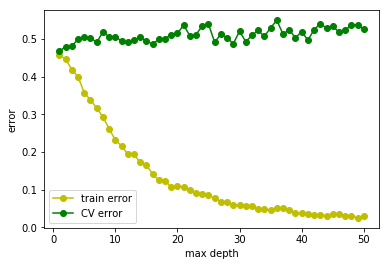

In [280]:
RF = [0]*50
RF_CVerror = [0]*50
for md in range(50):
    RF_CVerror[md] = 0.
    for i in range(10):
        RF_CVerror[md] = RF_CVerror[md]+0.1*RandomForest(CVset[i][0],CVset[i][1],CVset[i][2],CVset[i][3],md+1)[1]
    RF[md] = RandomForest(FORMALset[0],FORMALset[1],FORMALset[2],FORMALset[3],md+1)
RFtrain_error =[RF[md][0] for md in range(50)]
plt.plot(range(1, 51), RFtrain_error, '-yo', label = 'train error')
plt.plot(range(1, 51), RF_CVerror, '-go', label = 'CV error')
plt.ylabel('error')
plt.xlabel('max depth')
plt.legend(loc = 'lower left')
MD_chosen = np.argmin(RF_CVerror)+1
print "Minimum CV Error:",RF_CVerror[MD_chosen-1],"\t max_depth =",MD_chosen
print "Random Forests Model with K =",MD_chosen
print "Training Error:\t",RF[MD_chosen-1][0]
print "CV Error:\t",RF_CVerror[MD_chosen-1]
print "Test Error:\t",RF[MD_chosen-1][1]
print "Test True Positive Rate:\t",RF[MD_chosen-1][2]
print "Test False Positive Rate:\t",RF[MD_chosen-1][3]